In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_ta as ta
import mplfinance as mpf

In [2]:
# Volatility 10 Index_H1_201901010500_202109010000.csv
df = pd.read_csv('~/Python/projects/mlfin/data/Volatility 10 Index_H1_201901010500_202109010000.csv',
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date','time','open', 'high', 'low', 'close', 'tv', 'spread'],
                 sep='\t')

df['datetime'] = df['date'] + ' ' + df['time']

df.drop(['date', 'time', 'tv', 'spread'], axis= 1, inplace=True)

df.reset_index(drop=True, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

/home/sash/Python/projects/mlfin/env/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [4]:
print(df.head())
print()
print(df.info())

                         open      high       low     close
datetime                                                   
2019-01-01 05:00:00  7989.803  7990.783  7981.851  7985.697
2019-01-01 06:00:00  7985.807  7994.125  7984.129  7985.746
2019-01-01 07:00:00  7985.621  7991.298  7979.697  7985.078
2019-01-01 08:00:00  7984.991  7999.997  7983.987  7989.836
2019-01-01 09:00:00  7989.806  7992.654  7983.357  7985.492

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23371 entries, 2019-01-01 05:00:00 to 2021-09-01 00:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    23371 non-null  float64
 1   high    23371 non-null  float64
 2   low     23371 non-null  float64
 3   close   23371 non-null  float64
dtypes: float64(4)
memory usage: 912.9 KB
None


In [5]:
df['vl_oc'] = df['close'] - df['open']

<AxesSubplot:>

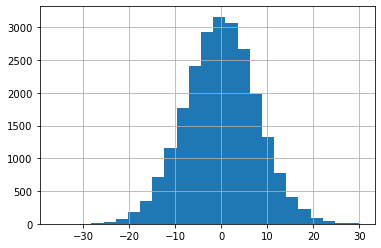

In [6]:
df['vl_oc'].hist(bins=25)

In [7]:
bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
df['vl_oc_binned'] = pd.cut(df['vl_oc'], bins)


In [8]:
def add_lags(data, ric, lags, barr=5.1, window=168):
    #cols = []
    dfd = pd.DataFrame(data[ric])
    dfd.dropna(inplace=True)
    #df['r'] = np.log(df / df.shift())
    # Простая МА
    dfd['sma'] = dfd[ric].rolling(window).mean()
    # Скользящий минимум
    dfd['min'] = dfd[ric].rolling(window).min()
    # Скользящий максимум
    dfd['max'] = dfd[ric].rolling(window).max()
    # Моментум как среднее значение логарифмической доходности
    #df['mom'] = df['r'].rolling(window).mean()
    # Скользящая волатильность
    dfd['vol'] = dfd[ric].rolling(window).std()
    df.dropna(inplace=True)
    # Волатильность как бинарный признак
    #dfd['d'] = np.where(abs(dfd[ric]-dfd[ric].shift(-1)) > barr, 1, 0)
    dfd['d'] = np.where(abs(dfd[ric].shift(-1)) > barr, 1, 0)
    #dfd['d'] = np.where(dfd[ric].shift(-1) > 0, 1, 0)
    features = [ric, 'd', 'sma', 'min', 'max', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            dfd[col] = dfd[f].shift(lag)
            #cols.append(col)
    dfd.dropna(inplace=True)
    return dfd

In [9]:
lags = 168
barr = 5.1
ric = 'vl_oc'
dfm = add_lags(df, ric, lags)

/tmp/ipykernel_14530/3725997314.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfd[col] = dfd[f].shift(lag)


In [10]:
dfm.head()

,vl_oc,sma,min,max,vol,d,vl_oc_lag_1,vl_oc_lag_2,vl_oc_lag_3,vl_oc_lag_4,...,vol_lag_159,vol_lag_160,vol_lag_161,vol_lag_162,vol_lag_163,vol_lag_164,vol_lag_165,vol_lag_166,vol_lag_167,vol_lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-15 04:00:00,-10.802,0.258905,-25.424,27.166,8.562677,1,5.786,-0.224,-0.748,-4.224,...,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019,8.027567,7.789425
2019-01-15 05:00:00,13.960,0.493333,-20.066,27.166,8.392762,1,-10.802,5.786,-0.224,-0.748,...,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019,8.027567
2019-01-15 06:00:00,8.904,0.575208,-20.066,27.166,8.407394,0,13.960,-10.802,5.786,-0.224,...,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019
2019-01-15 07:00:00,1.096,0.564173,-20.066,27.166,8.405475,0,8.904,13.960,-10.802,5.786,...,8.205101,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393
2019-01-15 08:00:00,5.014,0.677155,-20.066,27.166,8.336266,0,1.096,8.904,13.960,-10.802,...,8.240334,8.205101,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123


In [11]:
dfm = dfm.dropna()
dfm.head()

,vl_oc,sma,min,max,vol,d,vl_oc_lag_1,vl_oc_lag_2,vl_oc_lag_3,vl_oc_lag_4,...,vol_lag_159,vol_lag_160,vol_lag_161,vol_lag_162,vol_lag_163,vol_lag_164,vol_lag_165,vol_lag_166,vol_lag_167,vol_lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-15 04:00:00,-10.802,0.258905,-25.424,27.166,8.562677,1,5.786,-0.224,-0.748,-4.224,...,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019,8.027567,7.789425
2019-01-15 05:00:00,13.960,0.493333,-20.066,27.166,8.392762,1,-10.802,5.786,-0.224,-0.748,...,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019,8.027567
2019-01-15 06:00:00,8.904,0.575208,-20.066,27.166,8.407394,0,13.960,-10.802,5.786,-0.224,...,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393,8.036019
2019-01-15 07:00:00,1.096,0.564173,-20.066,27.166,8.405475,0,8.904,13.960,-10.802,5.786,...,8.205101,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123,8.039393
2019-01-15 08:00:00,5.014,0.677155,-20.066,27.166,8.336266,0,1.096,8.904,13.960,-10.802,...,8.240334,8.205101,8.190323,8.235979,8.112825,8.077407,8.092066,8.089978,8.099098,8.101123


In [160]:
# dfm.to_csv("dfm.csv")

Теперь делим dfm на обучающую и тестовые выборки и строим модель

In [12]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split

In [13]:

X = dfm.drop(['d'], axis=1)
y = dfm['d']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.25, random_state=42)

In [14]:
#learning with train and validation subsets
model = CatBoostClassifier(iterations=5000,
                        depth=6,
                        learning_rate=0.01,
                        custom_loss=['Accuracy'],
                        eval_metric='Accuracy',       
                        verbose=True,
                        random_strength=0.15,
                        use_best_model=True,
                        l2_leaf_reg=100,
                        random_seed=42,
                        task_type='CPU')
model.fit(X_train, y_train, eval_set = (X_validation, y_validation), early_stopping_rounds=50, plot=False)

0:	learn: 0.5530474	test: 0.5315159	best: 0.5315159 (0)	total: 368ms	remaining: 30m 40s
1:	learn: 0.5553626	test: 0.5408925	best: 0.5408925 (1)	total: 563ms	remaining: 23m 26s
2:	learn: 0.5551311	test: 0.5434971	best: 0.5434971 (2)	total: 793ms	remaining: 22m
3:	learn: 0.5558835	test: 0.5398507	best: 0.5434971 (2)	total: 985ms	remaining: 20m 30s
4:	learn: 0.5542050	test: 0.5424553	best: 0.5434971 (2)	total: 1.29s	remaining: 21m 26s
5:	learn: 0.5526422	test: 0.5424553	best: 0.5434971 (2)	total: 1.49s	remaining: 20m 39s
6:	learn: 0.5506743	test: 0.5434971	best: 0.5434971 (2)	total: 1.7s	remaining: 20m 14s
7:	learn: 0.5505585	test: 0.5452335	best: 0.5452335 (7)	total: 1.9s	remaining: 19m 47s
8:	learn: 0.5511952	test: 0.5440181	best: 0.5452335 (7)	total: 2.1s	remaining: 19m 27s
9:	learn: 0.5508479	test: 0.5473172	best: 0.5473172 (9)	total: 2.29s	remaining: 19m 4s
10:	learn: 0.5506743	test: 0.5462754	best: 0.5473172 (9)	total: 2.51s	remaining: 18m 58s
11:	learn: 0.5503849	test: 0.5438444	be

In [15]:
prediction = model.predict(X_validation)
proba = model.predict_proba(X_validation)
print(prediction[:20])
print(proba[:20])

[0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0]
[[0.50397934 0.49602066]
 [0.4940956  0.5059044 ]
 [0.49635436 0.50364564]
 [0.49670299 0.50329701]
 [0.49891311 0.50108689]
 [0.49450824 0.50549176]
 [0.49477074 0.50522926]
 [0.49294567 0.50705433]
 [0.50554816 0.49445184]
 [0.49494767 0.50505233]
 [0.50290374 0.49709626]
 [0.50103082 0.49896918]
 [0.49462629 0.50537371]
 [0.49941466 0.50058534]
 [0.5024065  0.4975935 ]
 [0.49415941 0.50584059]
 [0.49756442 0.50243558]
 [0.4963776  0.5036224 ]
 [0.49503045 0.50496955]
 [0.50396501 0.49603499]]


In [16]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'custom_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent'
}

In [17]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_validation, y_validation)

In [18]:
# Тут выводился график, для VSCode график отключил
modelt = CatBoostClassifier(**params)
modelt.fit(train_pool, eval_set=validate_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
modelt.save_model('model.py', format='python', pool=train_pool)

In [56]:
modelt.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['F1'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.06427200138568878,
 'score_function': 'Cos

In [126]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

In [131]:
curve = get_roc_curve(modelt, validate_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5294108856319562

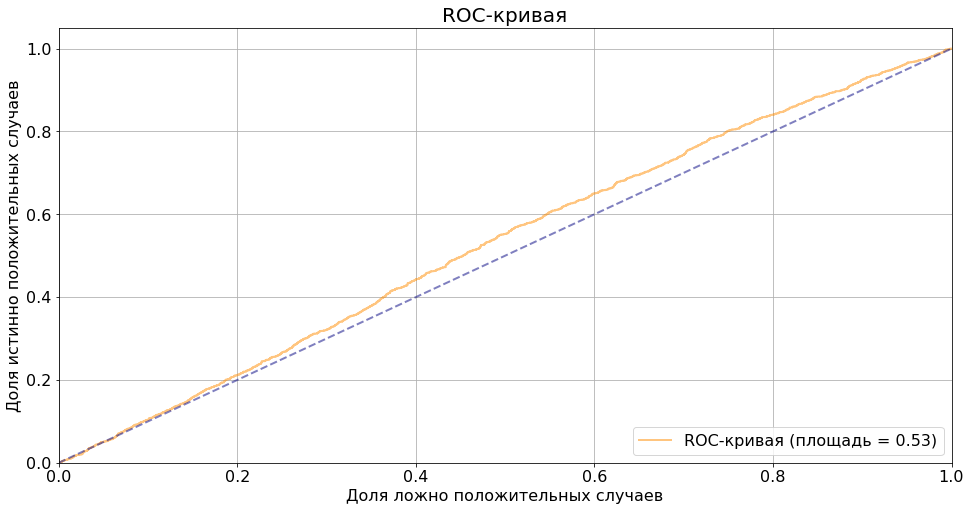

In [132]:
plt.figure(figsize=(16, 8))
lw=2
plt.plot (fpr, tpr, color='darkorange',
         lw=lw, label='ROC-кривая (площадь = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Доля ложно положительных случаев', fontsize=16)
plt.ylabel('Доля истинно положительных случаев', fontsize=16)
plt.title('ROC-кривая', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [130]:
model.get_feature_importance(train_pool,
                            fstr_type='PredictionValuesChange',
                            prettified=True)

,Feature Id,Importances
0,vl_oc_lag_19,6.122797
1,min_lag_3,5.743419
2,vol_lag_6,5.316925
3,min_lag_18,4.279532
4,min_lag_7,3.764639
...,...,...
144,vol_lag_14,0.000000
145,vol_lag_18,0.000000
146,vol_lag_19,0.000000
147,vol_lag_22,0.000000
